# Library Import and Set-Up

In [44]:
import numpy as np
import pandas as pd
from pickle import dump
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku
from tensorflow.keras import Sequential
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer


tf.config.run_functions_eagerly(True)
gpu_devices = tf.config.list_physical_devices('GPU')
details = tf.config.experimental.get_device_details(gpu_devices[0])
print("Available GPUs: ", details.get('device_name'))
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.6)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Available GPUs:  NVIDIA GeForce RTX 3060


I0000 00:00:1725337295.124566    3414 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725337295.125502    3414 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725337295.125530    3414 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725337295.125544    3414 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725337295.125697    3414 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-03

# Load Dataset

In [2]:
rawdataset = pd.read_csv("./dataset/full_dataset.csv")

In [35]:
print("Dataset shape:", rawdataset.shape)

Dataset shape: (2231142, 7)


In [3]:
dataset = rawdataset[:1800]
dataset = dataset.drop(["link", "source"], axis=1)

In [4]:
print("Data shape:", dataset.shape)
dataset.head()

Data shape: (1800, 5)


,Unnamed: 0,title,ingredients,directions,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...","[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....","[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...","[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...","[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...","[""peanut butter"", ""graham cracker crumbs"", ""bu..."


# Pre-Processing the Data

In [5]:
def clean_text(txt):
    txt = "".join(v for v in txt if v not in '!"#$%&*+:;<=>?@[\]^_`{}~').lower()
    return txt

title = [clean_text(x) for x in dataset.title]
NER = [clean_text(x) for x in dataset.NER]
ingredients = [clean_text(x) for x in dataset.ingredients]
directions = [clean_text(x) for x in dataset.directions]

#### Combining ner, title, ingredients and directions data into a single string

In [6]:
finaldataset = []
for i in range(len(NER)):
    finaldataset.append(NER[i]+" | "+title[i]+" | "+ingredients[i]+" | "+directions[i]+ " ~ ")
max_length = 0
for i in finaldataset:
    max_length = max(max_length, len(i))
print("max_length:", max_length)
print()
print("Recipe at index 0:\n", finaldataset[0])

max_length: 1362

Recipe at index 0:
 brown sugar, milk, vanilla, nuts, butter, bite size shredded rice biscuits | no-bake nut cookies | 1 c. firmly packed brown sugar, 1/2 c. evaporated milk, 1/2 tsp. vanilla, 1/2 c. broken nuts (pecans), 2 tbsp. butter or margarine, 3 1/2 c. bite size shredded rice biscuits | in a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine., stir over medium heat until mixture bubbles all over top., boil and stir 5 minutes more. take off heat., stir in vanilla and cereal mix well., using 2 teaspoons, drop and shape into 30 clusters on wax paper., let stand until firm, about 30 minutes. ~ 


# Tokenizing the final dataset

#### Creating Tokens

In [7]:
tokenizer = Tokenizer(
    char_level=False,
    filters='',
    lower=False,
    split=' '
)
tokenizer.fit_on_texts(finaldataset)
tokenizer.fit_on_texts(["~"])

vocab_size = len(tokenizer.word_index) + 1
print("Total words:", vocab_size)

text = ["pineapple condensed milk lemons pecans graham cracker crusts"]
token_list = tokenizer.texts_to_sequences(text)
print(text)
print(token_list)

Total words: 7144
['pineapple condensed milk lemons pecans graham cracker crusts']
[[182, 226, 91, 2790, 266, 191, 209, 1668]]


In [8]:
print("words and token:")
list(tokenizer.word_index.items())[100:110]

words and token:


[('cinnamon,', 101),
 ('garlic', 102),
 ('cool', 103),
 ('sprinkle', 104),
 ('onions,', 105),
 ('put', 106),
 ('egg', 107),
 ('5', 108),
 ('beef,', 109),
 ('together', 110)]

#### Vectorizing the dataset

In [9]:
finaldataset_token = tokenizer.texts_to_sequences(finaldataset)
print(finaldataset_token[2])
print()
print(tokenizer.sequences_to_texts([finaldataset_token[2]]))

[135, 206, 23, 30, 35, 102, 56, 14, 79, 2, 1043, 137, 2, 7, 331, 42, 54, 135, 206, 1, 159, 42, 54, 23, 30, 848, 139, 4, 35, 848, 6, 8, 102, 56, 6, 8, 14, 28, 8, 79, 2, 5, 17, 2174, 2977, 65, 77, 614, 122, 3, 57, 40, 237, 18, 43, 330, 21, 16, 805, 849, 3, 44, 127, 1364, 55, 152, 214, 550, 495, 80, 279, 10]

['frozen corn, cream cheese, butter, garlic powder, salt, pepper | creamy corn | 2 (16 oz.) pkg. frozen corn, 1 (8 oz.) pkg. cream cheese, cubed, 1/3 c. butter, cubed, 1/2 tsp. garlic powder, 1/2 tsp. salt, 1/4 tsp. pepper | in a slow cooker, combine all ingredients. cover and cook on low for 4 hours or until heated through and cheese is melted. stir well before serving. yields 6 servings. ~']


# Creating N-gram sequences

In [10]:
input_sequences = []
for line in finaldataset:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [11]:
for i in input_sequences[0:10]:
    print(i, tokenizer.sequences_to_texts([i]))

[52, 11] ['brown sugar,']
[52, 11, 36] ['brown sugar, milk,']
[52, 11, 36, 68] ['brown sugar, milk, vanilla,']
[52, 11, 36, 68, 187] ['brown sugar, milk, vanilla, nuts,']
[52, 11, 36, 68, 187, 35] ['brown sugar, milk, vanilla, nuts, butter,']
[52, 11, 36, 68, 187, 35, 934] ['brown sugar, milk, vanilla, nuts, butter, bite']
[52, 11, 36, 68, 187, 35, 934, 491] ['brown sugar, milk, vanilla, nuts, butter, bite size']
[52, 11, 36, 68, 187, 35, 934, 491, 179] ['brown sugar, milk, vanilla, nuts, butter, bite size shredded']
[52, 11, 36, 68, 187, 35, 934, 491, 179, 197] ['brown sugar, milk, vanilla, nuts, butter, bite size shredded rice']
[52, 11, 36, 68, 187, 35, 934, 491, 179, 197, 653] ['brown sugar, milk, vanilla, nuts, butter, bite size shredded rice biscuits']


In [12]:
max_seq_len = max(len(x) for x in input_sequences)
print("Input Sequences Length:", len(input_sequences))
print("Max sequences Length:", max_seq_len)

Input Sequences Length: 162958
Max sequences Length: 232


# Padding the sequences with 0

In [13]:
print("Before padding")
print(input_sequences[3], len(input_sequences[3]))

Before padding
[52, 11, 36, 68, 187] 5


In [14]:
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_seq_len, padding = 'pre'))

In [15]:
print("After padding")
print(input_sequences[3], len(input_sequences[3]))

After padding
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0  52  11  36  68 187] 232


# Spliting Predictor and Predictand

In [16]:
features, labels = input_sequences[:, :-1], input_sequences[:, -1]

In [17]:
print("Features Shape:", features.shape)
print("Labels Shape:", labels.shape)
print()
print("Data at index 3")
print("Features:", tokenizer.sequences_to_texts([features[3]]))
print("Labels:", tokenizer.sequences_to_texts([[labels[3]]]))

Features Shape: (162958, 231)
Labels Shape: (162958,)

Data at index 3
Features: ['brown sugar, milk, vanilla,']
Labels: ['nuts,']


In [18]:
print("dataset size in disk")
print("Features:", features.nbytes/1e+9)
print("Labels:", labels.nbytes/1e+9)

dataset size in disk
Features: 0.150573192
Labels: 0.000651832


In [19]:
labels = tf.keras.utils.to_categorical(labels, num_classes=vocab_size)

In [20]:
print("dataset size in disk")
print("Labels:", labels.nbytes/1e+9)
print("Labels Shape:", labels.shape)

dataset size in disk
Labels: 9.313375616
Labels Shape: (162958, 7144)


#### Reducing dataset size

In [21]:
n = 10
slice_size = int(len(features)/n)
print("Slice size:", slice_size)

Slice size: 16295


In [22]:
features = features[:slice_size, :]
labels = labels[:slice_size]

In [23]:
print("Features Shape:", features.shape)
print("Labels Shape:", labels.shape)
print("dataset size in disk")
print("Features:", features.nbytes/1e+9)
print("Labels:", labels.nbytes/1e+9)

Features Shape: (16295, 231)
Labels Shape: (16295, 7144)
dataset size in disk
Features: 0.01505658
Labels: 0.93129184


# Model Training

In [24]:
def generator_model():
    model = Sequential([
    Embedding(vocab_size, 256, input_length=max_seq_len),
    GRU(126),
    Dense(vocab_size, activation='softmax')
    ])
    model.compile(loss = 'categorical_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002),
              metrics = ['accuracy'])
    return model

In [25]:
model = generator_model()

/home/rahul/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1725336666.639841    3414 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725336666.640090    3414 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725336666.640179    3414 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725336666.640546    3414 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-03 09:41:06.640582: I tensor

In [26]:
history = model.fit(features, labels, epochs = 25, batch_size=64)

/home/rahul/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25


2024-09-03 09:41:18.754617: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


255/255 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.0434 - loss: 7.3399
Epoch 2/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.1308 - loss: 5.6127
Epoch 3/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.2168 - loss: 4.6450
Epoch 4/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.2681 - loss: 3.9929
Epoch 5/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.3275 - loss: 3.3862
Epoch 6/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.3720 - loss: 2.9436
Epoch 7/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.4649 - loss: 2.4244
Epoch 8/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.5322 - loss: 2.0455
Epoch 9/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.5962 - loss: 1.7246
Epoch 10/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.6603 - loss: 1.4436
Epoch 11/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7094 - loss: 1.2311
Epoch 12/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 

#### Model Summary

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 231, 256)         │     1,828,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (64, 126)              │       145,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 7144)             │       907,288 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,643,914 (32.97 MB)

 Trainable params: 2,881,304 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,762,610 (21.98 MB)

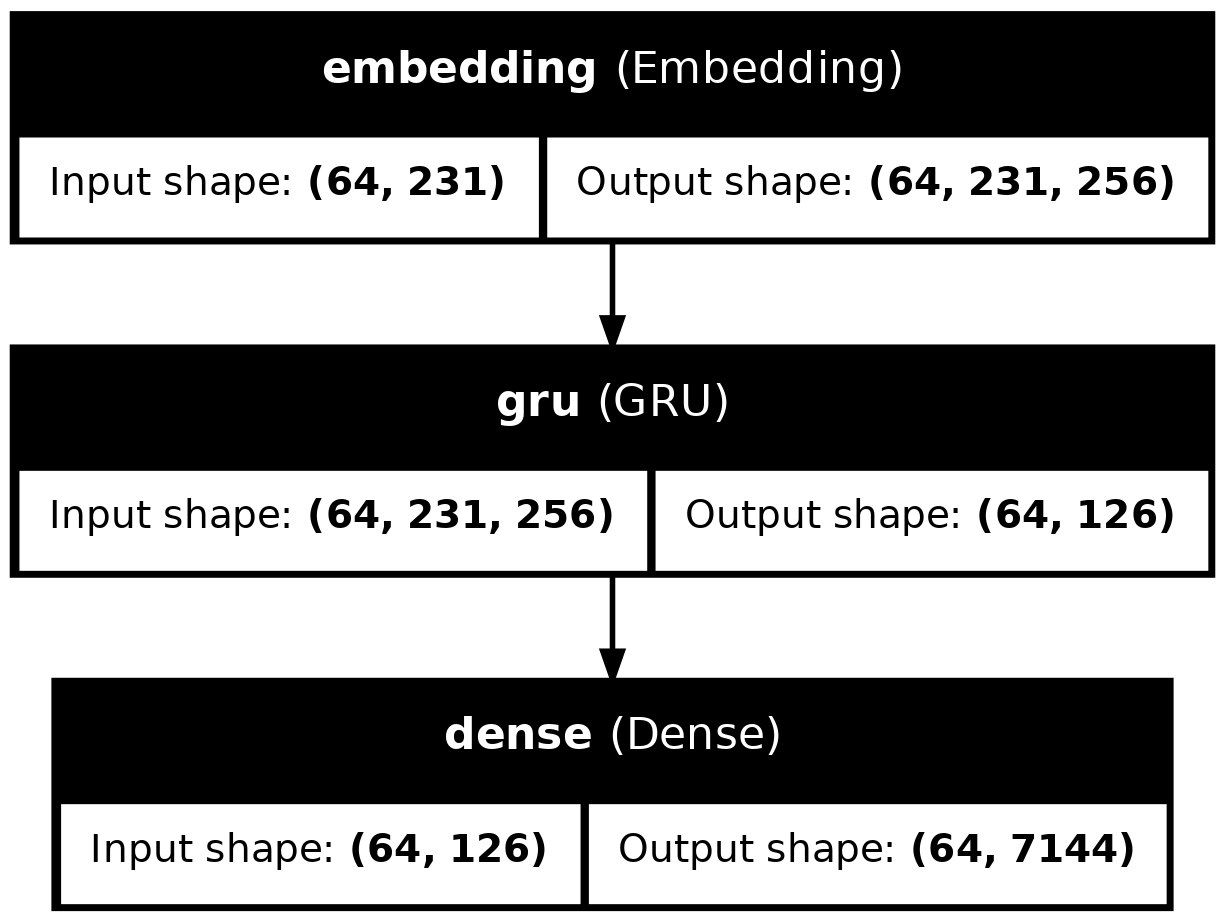

In [28]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [29]:
print("Model Accuracy:", max(history.history['accuracy']))
print("Loss:", min(history.history['loss']))

Model Accuracy: 0.9656950235366821
Loss: 0.20192410051822662


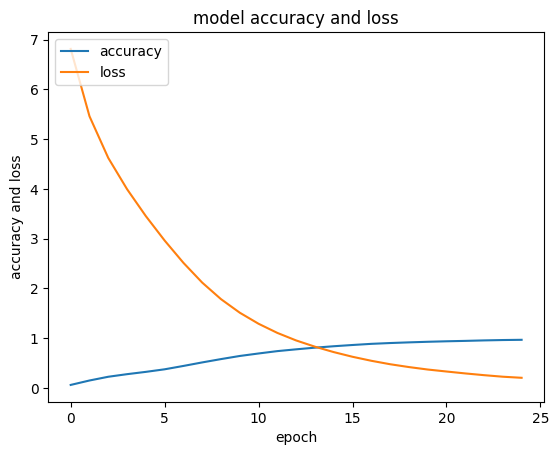

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy and loss')
plt.ylabel('accuracy and loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

# Model Testing

In [40]:
def generate_text(seed_text):
    for _ in range(max_seq_len):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding = "pre")
        predicted = model.predict(token_list, verbose=0)
        predicted = np.argmax(predicted, axis=-1)
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                if(word == "~"):
                    return seed_text
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text

In [49]:
ing = "hearts, mayonnaise, parmesan cheese"
print("Ingredients:", ing)
print("\nPredicted Recipe:")
print(generate_text(ing))

Ingredients: hearts, mayonnaise, parmesan cheese

Predicted Recipe:
hearts, mayonnaise, parmesan cheese | artichoke dip | 2 cans or jars artichoke hearts, 1 c. mayonnaise, 1 c. parmesan cheese | drain artichokes and chop., mix with mayonnaise and parmesan cheese., after well mixed, bake, uncovered, for 20 to 30 minutes at 350u00b0., serve with crackers.


In [42]:
print("Actual Data:")
print(finaldataset[37])
print("\nPredicted Data:")
generate_text("salad supreme, italian dressing")

Actual Data:
salad supreme, italian dressing | summer spaghetti | 1 lb. very thin spaghetti, 1/2 bottle mccormick salad supreme (seasoning), 1 bottle zesty italian dressing | prepare spaghetti per package., drain., melt a little butter through it., marinate overnight in salad supreme and zesty italian dressing., just before serving, add cucumbers, tomatoes, green peppers, mushrooms, olives or whatever your taste may want. ~ 

Predicted Data:


'salad supreme, italian dressing | summer spaghetti | 1 lb. very thin spaghetti, 1/2 bottle mccormick salad supreme (seasoning), 1 bottle zesty italian dressing | prepare spaghetti per package., drain., melt a little butter through it., marinate overnight in salad supreme and zesty italian dressing., just before serving, add cucumbers, tomatoes, green peppers, mushrooms, olives or whatever your taste may want.'

# Saving the model and word index

In [45]:
model.save("Culinary-Companion-V0.1.keras")
with open('Culinary-Companion-word_index.pickle', 'wb') as handle:
    dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)